# **Comparison of Importance Metrics for Feature Selection**
I like to return to the Titanic competition to test new concepts I'm learning, so this time I wanted to take a look at different feature importance metrics and what they tell us about this dataset, to inform feature selection and engineering.

In particular, I will compare: 
1. Mutual information scores
2. Permutation importance
3. Partial dependence plots
4. SHAP values

Since some of these metrics operate on a fitted model, I will compare **7 baselines models** to illustrate differences and similarities.

Let's dive in! 🤿

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Models
from sklearn.ensemble._forest import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.gaussian_process._gpc import GaussianProcessClassifier
from sklearn.ensemble._gb import GradientBoostingClassifier
from sklearn.ensemble._hist_gradient_boosting.gradient_boosting import HistGradientBoostingClassifier
from sklearn.neural_network._multilayer_perceptron import MLPClassifier
from sklearn.svm._classes import SVC
from sklearn.linear_model._ridge import RidgeClassifier

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (4,4)

seed = 17

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **Preprocessing**

Here we load the data and perform a check on missing values. Subsequently, we address those missing values by imputation or by dropping the feature if it not of interest. In this case I drop right away *"Name", "Ticket", "Cabin", "PassengerId"*.

In [2]:
training_set = pd.read_csv("/kaggle/input/titanic/train.csv")
submission_set = pd.read_csv("/kaggle/input/titanic/test.csv")

In [3]:
training_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#Check which columns have missing values
print("Missing values in training set : ")
print(training_set.isna().sum())

print("\nMissing values in submission set : ")
print(submission_set.isna().sum())

Missing values in training set : 
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Missing values in submission set : 
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [5]:
X = training_set.copy()

# We apply all transformations both to the trainig set and the submission set
X_subm = submission_set.copy()

# We remove the target column from the training data 
y = X.pop("Survived")

# We choose which features to ignore from starters and drop them
columns_to_drop = ["Name", "Ticket", "Cabin", "PassengerId"]
X = X.drop(columns=columns_to_drop)
X_subm = X_subm.drop(columns=columns_to_drop)

# We fill the missing values in the training and submission sets
X["Age"].fillna(X["Age"].median(), inplace = True)
X["Embarked"].fillna("UNK", inplace = True)
X_subm["Age"].fillna(X["Age"].median(), inplace = True)
X_subm["Fare"].fillna(X_subm["Fare"].median(), inplace = True)

# We encode categorical variables to a numerical representation
enc_sex = LabelEncoder()
X["Sex"] = enc_sex.fit_transform(X["Sex"])
X_subm["Sex"] = enc_sex.transform(X_subm["Sex"])
enc_emb = LabelEncoder()
X["Embarked"] = enc_sex.fit_transform(X["Embarked"])
X_subm["Embarked"] = enc_sex.transform(X_subm["Embarked"])

# And we split it in train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=seed)


# **Training the models**

Here we train a group of baseline models using all the features and compute the accuracy on the test set.

In [6]:
# Dictionary of models to test
models = {
     "RandomForest" : RandomForestClassifier(random_state=seed),
     "LogisticRegression" : LogisticRegression(solver="liblinear", random_state=seed),
     "XGB" : XGBClassifier(random_state=seed),
     "GaussianProcess" : GaussianProcessClassifier(random_state=seed),
     "HistGradientBoosting" : HistGradientBoostingClassifier(random_state=seed),
     "MLP" : MLPClassifier(hidden_layer_sizes=(100, 100, 100),
                           max_iter=1000, 
                           activation = "logistic",
                           random_state=seed),
     "SVC" : SVC(random_state=seed),
    }

In [7]:
for n, (model_name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    score = accuracy_score(y_test, preds)
    
    print('Accuracy of',model_name, ':' , np.round(score, 4))

Accuracy of RandomForest : 0.7989
Accuracy of LogisticRegression : 0.7765
Accuracy of XGB : 0.8045
Accuracy of GaussianProcess : 0.6816
Accuracy of HistGradientBoosting : 0.8212
Accuracy of MLP : 0.7877
Accuracy of SVC : 0.676


# **Mutual information**

The ***mutual information score*** is a non-parametric measure that quantifies the dependence between two variables, regardless of their distribution. The mutual information score ranges from 0 (indicating no relationship between the variables) to a maximum value (indicating a perfect relationship). It can be used in feature selection, clustering, and classification tasks, where the aim is to identify the most informative variables for a given problem. Mutual information scores are calculated on the data, rather than on the specific fitted model. 

Documentation for **[mutual_info_regression](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html)** from the scikit-learn library.

**Observation**: the score tells us that only ***Sex***, ***Age***, ***Pclass*** and ***Fare*** have some level of impact on the survival predictions, in decreasing order of importance. This suggests that excluding Embarked, Parch and SibSp may be possible without a significan loss in predictive ability by the models.

In [8]:
from sklearn.feature_selection import mutual_info_regression

X_mi = X_train.copy()

for colname in X_mi.columns:
    X_mi[colname], _ = X_mi[colname].factorize()

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y, random_state = seed)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X_mi, y_train)

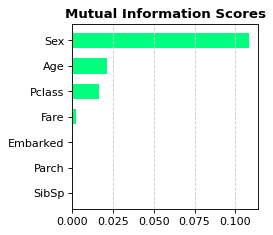

In [9]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores, height = 0.6, color = "springgreen")
    plt.yticks(width, ticks)
    #plt.xticks([0.01*i for i in range(20)])
    plt.title("Mutual Information Scores", weight='bold')

plt.figure(figsize=(3, 3), dpi=80)
fig = plt.gcf()
fig.tight_layout()
plt.grid(axis='x', linestyle='--', color='0.8')
plot_mi_scores(mi_scores)

# **Permutation importance**

***Permutation importance*** is calculated considering a model predictions for the test set and performing random permutations of the values of a given feature. If the prediction is insensitive to these permutation for a given feature, its permuatation importance score will be low, and this means that the model does not rely on this feature to predict the target, therefore this variable can be ignored. 

Documentation for **[PermutationImportance](https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html)**

**Observation**: each model considers a different subset of features important. The majority model concur in deriving most information out of *"Sex"*, but for some it is *"Fare"* that has the highest score. Overall *"Embarked"*, *"SibSp"* and *"Parch"* score low for all models, in accordance with the Mutual Information results, except LogisticRegression and GaussianProcess that have a 0.02 score for *"SibSp"*

In [10]:
import eli5
from eli5.sklearn import PermutationImportance
from IPython.display import display

for n, (model_name, model) in enumerate(models.items()):
    perm = PermutationImportance(model, random_state=seed).fit(X_test, y_test)
    print("\n",model_name)
    display(eli5.show_weights(perm, feature_names = list(X_test.columns)))



 RandomForest


Weight,Feature
0.1497 ± 0.0370,Sex
0.0737 ± 0.0311,Pclass
0.0570 ± 0.0342,Age
0.0547 ± 0.0179,Fare
0.0123 ± 0.0239,SibSp
-0.0067 ± 0.0239,Parch
-0.0112 ± 0.0255,Embarked



 LogisticRegression


Weight,Feature
0.1933 ± 0.0750,Sex
0.0212 ± 0.0217,SibSp
0.0112 ± 0.0234,Pclass
0.0056 ± 0.0100,Parch
0.0022 ± 0.0134,Fare
-0.0078 ± 0.0089,Embarked
-0.0078 ± 0.0270,Age



 XGB


Weight,Feature
0.1542 ± 0.0261,Sex
0.0816 ± 0.0230,Pclass
0.0637 ± 0.0391,Fare
0.0592 ± 0.0358,Age
0.0034 ± 0.0219,Embarked
0.0000 ± 0.0223,SibSp
-0.0145 ± 0.0219,Parch



 GaussianProcess


Weight,Feature
0.1006 ± 0.0845,Fare
0.0268 ± 0.0277,Sex
0.0246 ± 0.0055,SibSp
0.0235 ± 0.0179,Age
0.0145 ± 0.0152,Pclass
-0.0011 ± 0.0130,Embarked
-0.0067 ± 0.0179,Parch



 HistGradientBoosting


Weight,Feature
0.1721 ± 0.0192,Sex
0.0883 ± 0.0164,Pclass
0.0637 ± 0.0270,Age
0.0603 ± 0.0205,Fare
0.0156 ± 0.0084,SibSp
-0.0034 ± 0.0288,Embarked
-0.0045 ± 0.0084,Parch



 MLP


Weight,Feature
0.1765 ± 0.0610,Sex
0.0302 ± 0.0350,Age
0.0257 ± 0.0313,SibSp
0.0089 ± 0.0270,Pclass
0.0045 ± 0.0192,Fare
-0.0045 ± 0.0109,Parch
-0.0045 ± 0.0084,Embarked



 SVC


Weight,Feature
0.0983 ± 0.0364,Fare
0.0034 ± 0.0089,Age
0 ± 0.0000,Embarked
0 ± 0.0000,Parch
0 ± 0.0000,SibSp
0 ± 0.0000,Sex
0 ± 0.0000,Pclass


Now let's retrain the models using only the subset of features with a weight greater than 0.01 and recalculate the accuracy. In 6 out of 7 cases **excluding the uninformative features increased the accuracy of the predictions**!

In [11]:
to_keep = {
     "RandomForest" : ["Sex", "Pclass", "Age", "Fare", "SibSp"],
     "LogisticRegression" : ["Sex", "Pclass", "SibSp"],
     "XGB" : ["Sex", "Pclass", "Age", "Fare"],
     "GaussianProcess" : ["Sex", "Pclass", "Age", "Fare", "SibSp"],
     "HistGradientBoosting" : ["Sex", "Pclass", "Age", "Fare", "SibSp"],
     "MLP" : ["Sex", "Age", "SibSp"],
     "SVC" : ["Fare", "Age"],
    }

In [12]:
for n, (model_name, model) in enumerate(models.items()):
    model.fit(X_train[to_keep[model_name]], y_train)
    preds = model.predict(X_test[to_keep[model_name]])
    score = accuracy_score(y_test, preds)
    
    print('Accuracy of',model_name, ':' , np.round(score, 4))

Accuracy of RandomForest : 0.8045
Accuracy of LogisticRegression : 0.7877
Accuracy of XGB : 0.8268
Accuracy of GaussianProcess : 0.6927
Accuracy of HistGradientBoosting : 0.8045
Accuracy of MLP : 0.7989
Accuracy of SVC : 0.6816


### **Comparison of accuracy with all features or only with relevant features for each model**
|Model| Accuracy with all features | With reduced features set|
|----|-----|----|
|RandomForest|0.7989 | 0.8045|
|  LogisticRegression|0.7765 | 0.7877|
|  XGB|0.8045 | 0.8268|
|  GaussianProcess|0.6816 | 0.6927|
|  HistGradientBoosting|0.8212 | 0.8045|
|  MLP|0.7877 | 0.7989|
|  SVC|0.6760 | 0.6816|

# **Partial Dependence Plots**

Partial dependence plots can help us visualize the relationship between the target variable (Survival) and a specific feature *while keeping other variables constant*. They provide insights into how each feature impacts the target, revealing trends, interactions, and non-linearities. 

For example, we can see that, for all models that used Sex as a feature, 0 (Female) has a higher correlation with Survival than 1 (Male). Concerning features with continuous values, such as Age, for almost all models, the highest correlation with survival is found in the case of infants. 

Another interesting example is looking at the SibSp plot for the GasussianProcess model. What this trend is telling us is that single people have the lowest correlation with survival, but that beyond 1 sibling or spouse there isn't added benefit in belonging to larger families in terms of survival chances.

Documentation for **[PartialDependenceDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.PartialDependenceDisplay.html)**

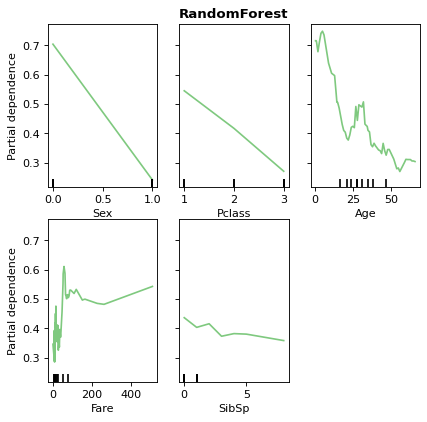

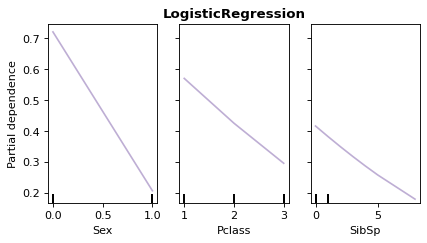

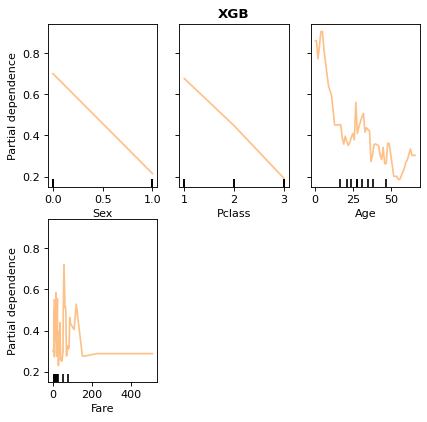

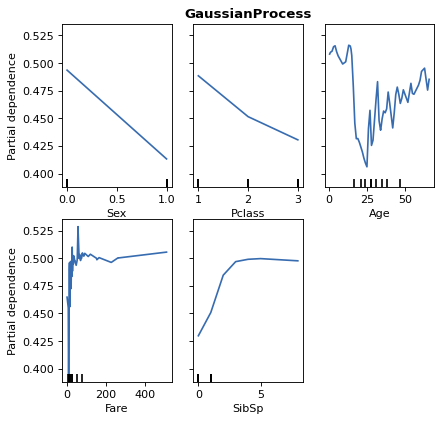

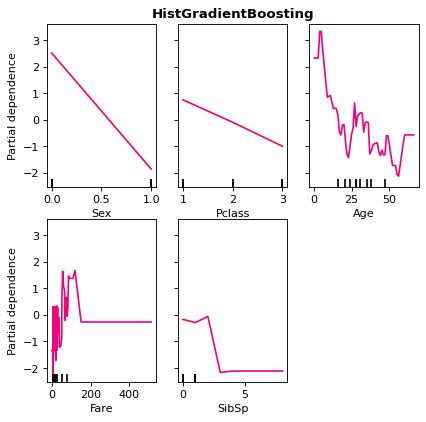

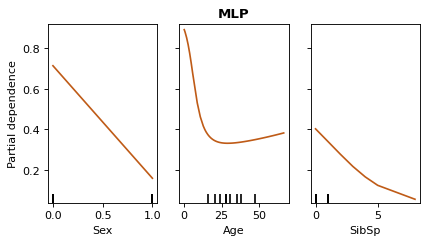

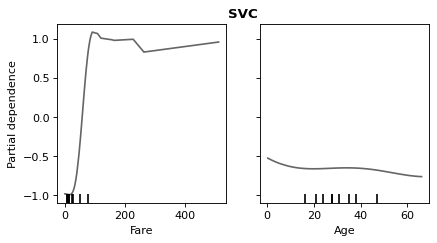

In [13]:
from sklearn.inspection import PartialDependenceDisplay

colors = plt.get_cmap("Accent")(np.linspace(0., 1., 7))

for n, (model_name, model) in enumerate(models.items()):
    figsize = (6, 3) if len(to_keep[model_name])>3 else (6, 1.5)
    fig, ax = plt.subplots(figsize=figsize, dpi=80)
    ax.set_title(model_name, weight='bold')
    display = PartialDependenceDisplay.from_estimator(model, X_test[to_keep[model_name]], to_keep[model_name], 
                                                      ax=ax, line_kw={"color": colors[n]})    
    plt.subplots_adjust(top=1.6)
    plt.show()

Interestingly, we can also explore 2D partial dependence plot, to uncover interaction between the features. Below are two examples.

### **Age & Fare in the SVC model**

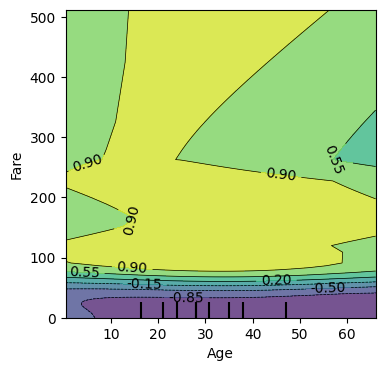

In [14]:
fig, ax = plt.subplots()
fnames = [('Age', 'Fare')]
disp = PartialDependenceDisplay.from_estimator(models["SVC"], X_test[to_keep["SVC"]], fnames, ax=ax)
plt.show()

### **Age & Sex in the MLP model**

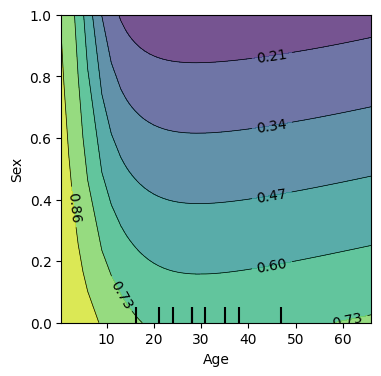

In [15]:
fig, ax = plt.subplots()
fnames = [('Age', 'Sex')]
disp = PartialDependenceDisplay.from_estimator(models["MLP"], X_test[to_keep["MLP"]], fnames, ax=ax)
plt.show()

# **SHAP**

SHAP (Shapley Additive Explanations) assigns importance values to each feature in a prediction model, quantifying its contribution towards the prediction outcome. In this way, it can be clarified what led to a given prediction, providing a comprehensive understanding of feature impact and facilitating model explanation and evaluation.

In the following I compared for example the predictions of all models for the first entry in the test set

Exact explainer: 180it [00:15,  5.91it/s]                         

RandomForest


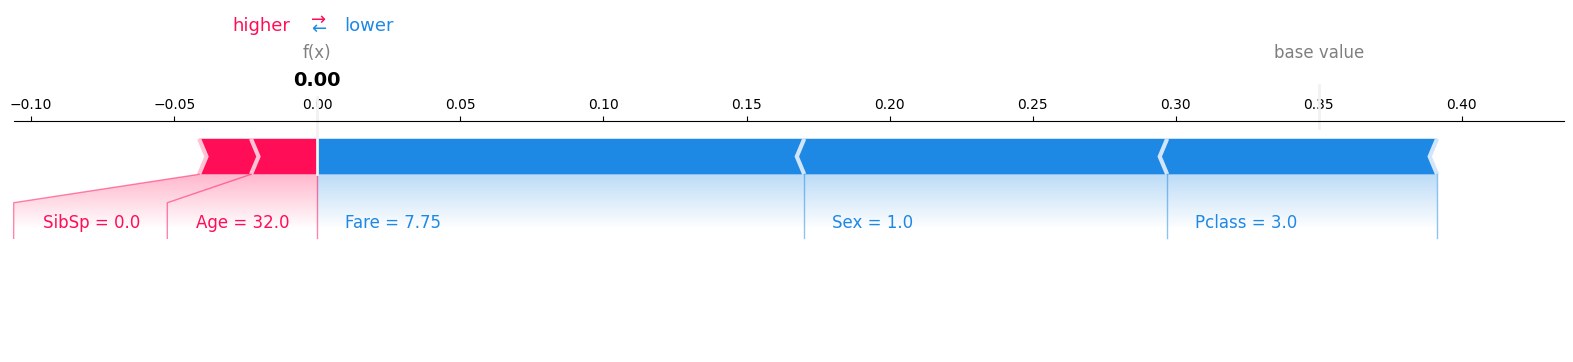

LogisticRegression


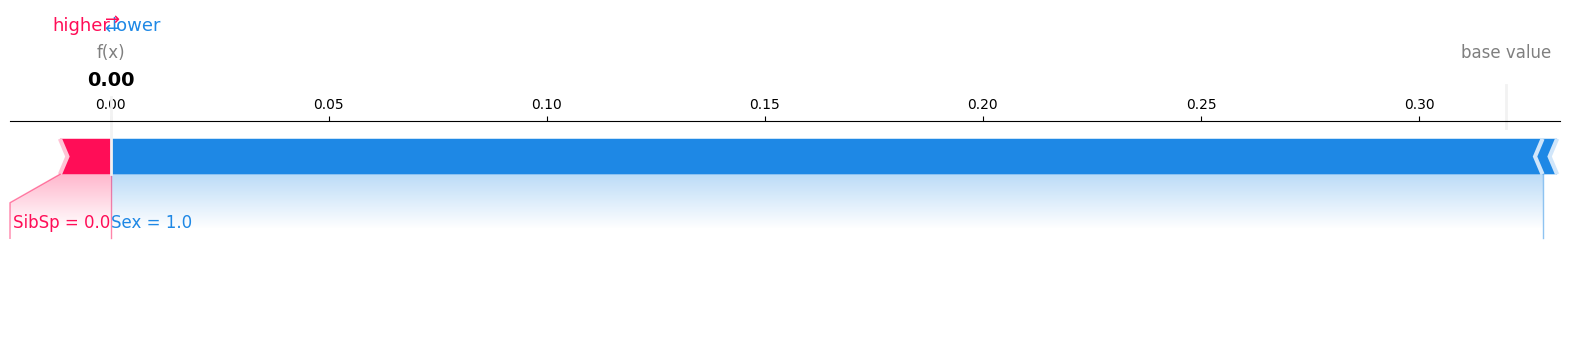

XGB


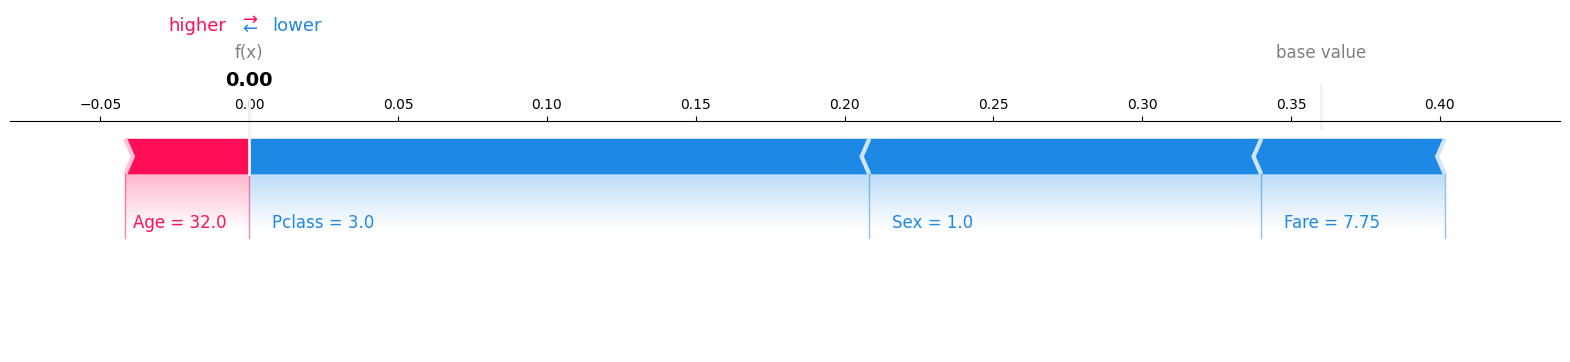

Exact explainer: 180it [00:23,  4.30it/s]

GaussianProcess


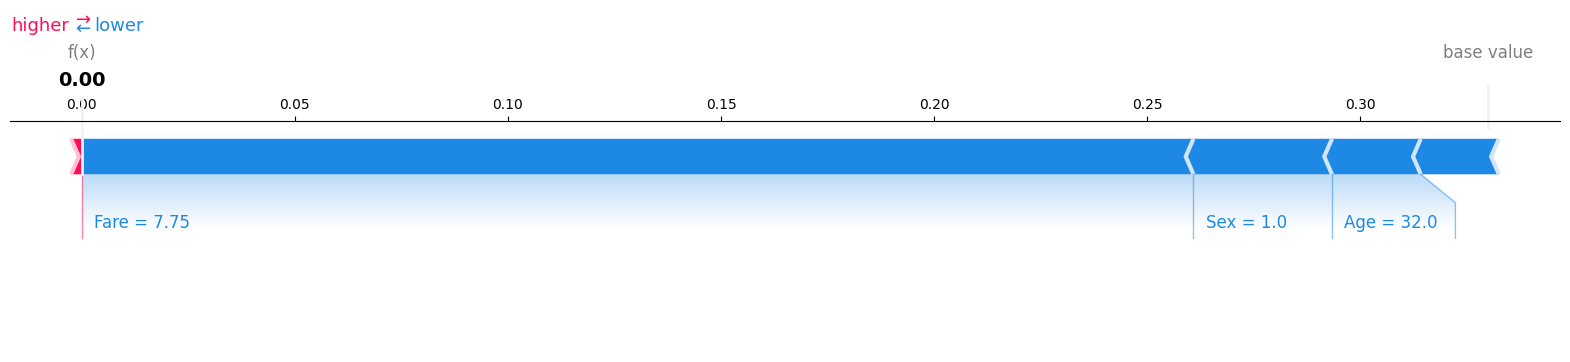

HistGradientBoosting


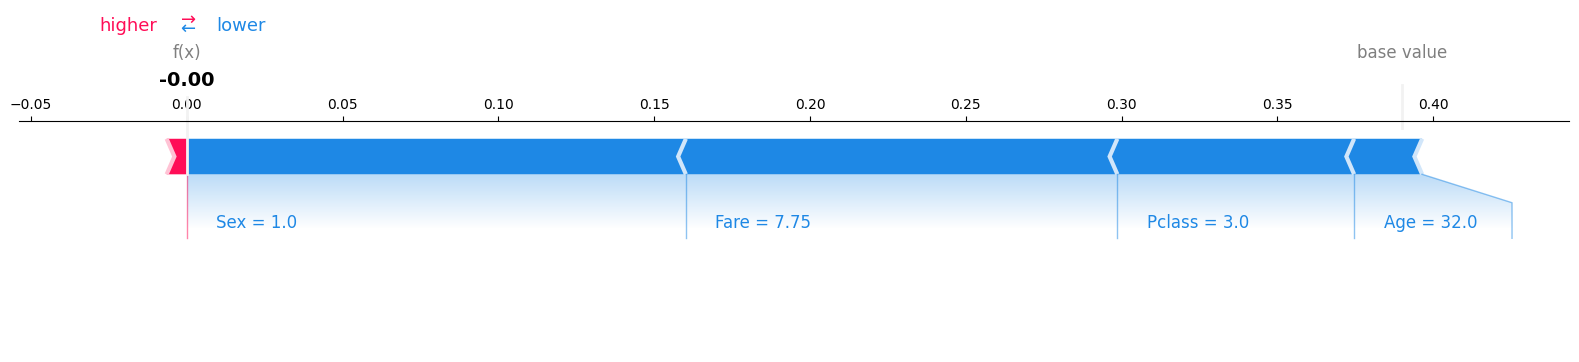

MLP


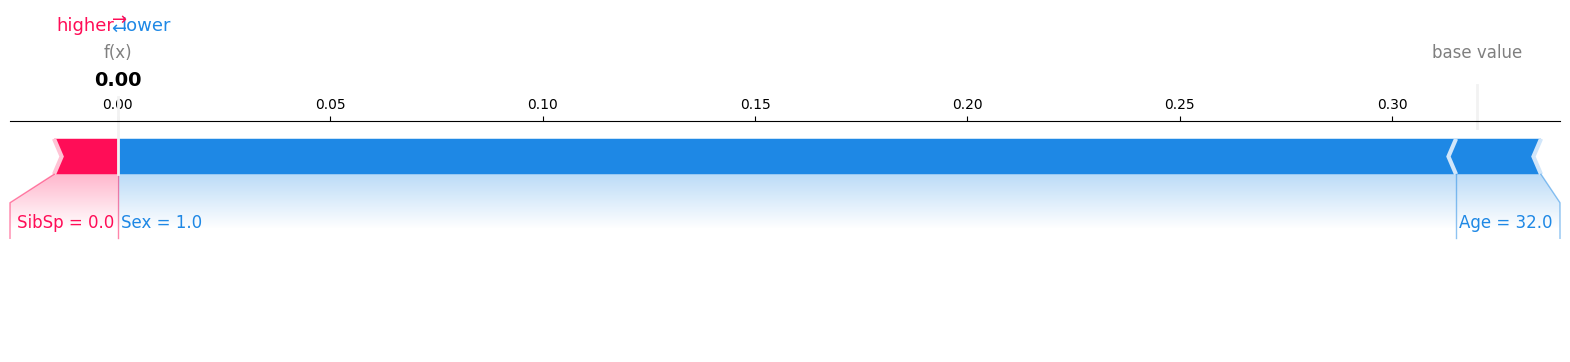

SVC


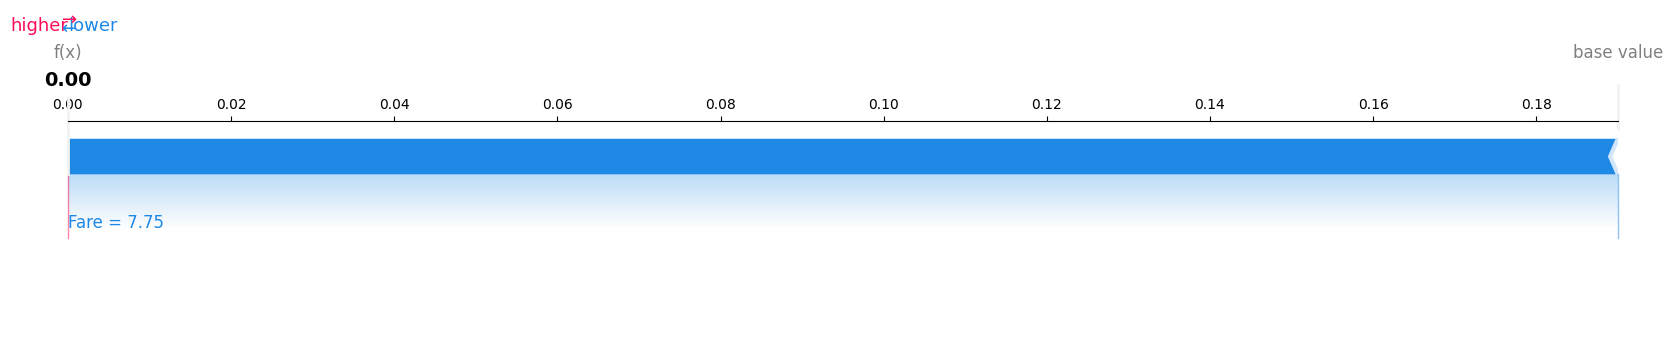

In [16]:
import shap  

for n, (model_name, model) in enumerate(models.items()):
    # Fits the explainer
    explainer = shap.Explainer(model.predict, X_test[to_keep[model_name]])
    # Calculates the SHAP values - It takes some time
    shap_values = explainer(X_test[to_keep[model_name]])
    #shap.plots.bar(shap_values[0])
    print(model_name)
    shap.initjs()
    shap.plots.force(shap_values[0], matplotlib = True, show = True)

In addition to single predictions, we can get also look at summary plots for all the entries in the dataset. Below I plotted the results for the XGB model. It can be seen, for example, that high values of "Sex", (red =  male), reduces the value of the prediction, which tranelates to a lower survival chance. If we look at Age, on the other hand, we can see a strong effect on the prediction for the extreme values (very high age lowers the predicions, very low age increases it) and a more modest effect for the intermediate values (purple), that tend to cluster around zero.

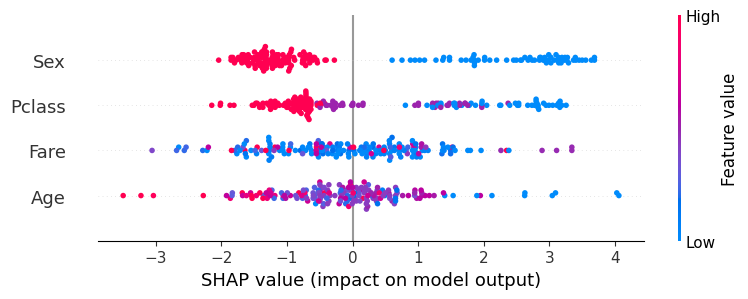

In [17]:
explainer = shap.TreeExplainer(models["XGB"])
shap_values = explainer.shap_values(X_test[to_keep["XGB"]])
shap.summary_plot(shap_values, X_test[to_keep["XGB"]])

# **Submission**
After we have completed all preliminary analysis and chosen the best modelling approach, we can retrain the best model using the whole training data to further increase its accuracy (in this final stage the test set is actually the one used to score the submission) and submit our predicitions.

In [18]:
models["XGB"].fit(X[to_keep["XGB"]], y)

results = models["XGB"].predict(X_subm[to_keep["XGB"]])

submission_df = pd.DataFrame({'PassengerId': submission_set['PassengerId'], 'Survived': results})
submission_df.to_csv('submission.csv', index=False)

I hope this walkthrough was helpful to learn more about different ways to inspect feature importance. A big takeaway is that feature importance is tightly connected to all other modelling choices performed (model, preprocessing etc..) and there isn't a unique set of importance features for a given task. 

Any feedback or question is more than welcome!! 🧐